In [71]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
data = pd.read_csv("BacNinh.csv", parse_dates=["date"], index_col=["date"])
start_date = '2019-03-01'
end_date = '2024-03-01'
df = data.loc[start_date:end_date]
df

,Unnamed: 0,pm25,pm10,o3,no2,so2,co,AQI
date,,,,,,,,
2020-06-20,1,66,21,35,9,3,3,66
2020-06-21,2,25,18,32,9,3,2,25
2020-06-22,3,22,24,95,9,5,2,24
2020-06-23,4,25,30,34,9,6,3,30
2020-06-24,5,32,38,21,9,5,4,38
...,...,...,...,...,...,...,...,...
2024-02-26,1162,71,26,11,5,16,1,71
2024-02-27,1163,36,51,7,8,17,2,51
2024-02-28,1164,85,29,15,5,17,2,85


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1166 entries, 2020-06-20 to 2024-03-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  1166 non-null   int64
 1   pm25        1166 non-null   int64
 2   pm10        1166 non-null   int64
 3   o3          1166 non-null   int64
 4   no2         1166 non-null   int64
 5   so2         1166 non-null   int64
 6   co          1166 non-null   int64
 7   AQI         1166 non-null   int64
dtypes: int64(8)
memory usage: 82.0 KB


In [74]:
df_aqi = pd.DataFrame(df["AQI"])

In [75]:
timesteps = df_aqi.index.to_numpy()
aqi_arr = df_aqi["AQI"].to_numpy()

In [76]:
timesteps

array(['2020-06-20T00:00:00.000000000', '2020-06-21T00:00:00.000000000',
       '2020-06-22T00:00:00.000000000', ...,
       '2024-02-28T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [77]:
aqi_arr

array([66, 25, 24, ..., 85, 44, 63])

**Building and testing he N-BEATS block layer**

In [78]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon:    int,
               n_neurons:  int,
               n_layers:   int,
               **kwargs):


    super().__init__(**kwargs)
    self.input_size= input_size
    self.theta_size= theta_size
    self.horizon = horizon
    self.n_neurons= n_neurons
    self.n_layers= n_layers

    self.hidden=[tf.keras.layers.Dense(n_neurons, activation='relu', name=f"Fully_Connected_Layer_{i}") for i in range(1,n_layers+1) ]
    self.theta_layer=tf.keras.layers.Dense(theta_size, activation='linear',name='theta')


  def call(self,inputs):

    x= inputs

    for layer in self.hidden :
      x= layer(x)

    theta= self.theta_layer(x)

    # output the backcast and forecast
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast


**Making dummy inputs and outputs for testing our NBeatsBlock class**

In [79]:
WINDOW_SIZE=100
HORIZON=1
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=HORIZON+WINDOW_SIZE,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs


# passing dummy inputs
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")



Backcast: [-10.603103     9.058776     0.27599144  -3.8381455   -2.9263
 -10.385403   -10.783215    -2.0237577   -3.5416691   -6.6225376
  -0.26940644  -4.1274533   10.913962    -5.7567053   -7.436454
   5.5127287    0.3573079  -13.43426     -9.000274    -0.08601809
  -4.077284     8.815891    -1.339849    -5.515936    -5.820735
  -6.507877   -11.394225     2.1052742   -1.0961123   -4.114806
 -12.947807     9.11291     13.010004    13.39951     -7.6651273
   5.3156786    2.8932922   -6.249915    -8.130223    -8.019487
 -10.097407   -10.178176    -8.076723   -14.981644    -0.6311032
  10.107167     1.8855588    8.704281     7.246877     3.9509048
  -0.12596989  -1.2207079    4.6792564  -11.524975     4.579065
  -6.318575    -6.033862     3.320445    12.636481     7.987714
  -7.906594     3.2111309    2.6376424   -3.90729     -5.616479
   5.8616157   -1.4345826   -5.6598372    2.8333287    4.628249
  -7.089609     9.40642     -5.4292774    0.25687408   3.4815009
   4.044871     7.173587 

**Preparing data for the N-BEATS algorithm using tf.data**

In [80]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2020-06-20,66
2020-06-21,25
2020-06-22,24
2020-06-23,30
2020-06-24,38
...,...
2024-02-26,71
2024-02-27,51
2024-02-28,85


In [81]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2020-09-18,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0,25.0,66.0
2020-09-19,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0,25.0
2020-09-20,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0
2020-09-21,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0
2020-09-22,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,59.0,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,71,44.0,31.0,115.0,92.0,109.0,108.0,80.0,97.0,111.0,...,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0,128.0,74.0
2024-02-27,51,71.0,44.0,31.0,115.0,92.0,109.0,108.0,80.0,97.0,...,214.0,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0,128.0
2024-02-28,85,51.0,71.0,44.0,31.0,115.0,92.0,109.0,108.0,80.0,...,176.0,214.0,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0


**NBEATS(7:3)**

In [82]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [83]:
split_size = int(len(x) * 0.7)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(816, 816, 350, 350)

In [84]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Setting up hyperparameters for N-BEATS algorithm**

In [85]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

**Getting ready for residual connections**

In [86]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


**Building, compiling and fitting the N-BEATS algorithm**

In [87]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [88]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 304ms/step - loss: 30.8649 - mae: 30.8649 - mse: 1604.6234


[30.86493492126465, 30.86493492126465, 1604.6234130859375]

In [89]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [90]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 30.864935, 'rmse': 40.05775, 'mape': 97.34294}

**Make predictions into future**

In [91]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [92]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-19    217
2023-11-20    220
2023-11-21    229
2023-11-22    207
2023-11-23    200
             ... 
2024-02-26     71
2024-02-27     51
2024-02-28     85
2024-02-29     44
2024-03-01     63
Name: AQI, Length: 90, dtype: int64 -> Prediction: 177.41725158691406

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [220.         229.         207.         200.         214.
 176.         188.         203.         210.         219.
 194.          60.         103.         100.          67.
 111.         116.         148.         158.         164.
 114.          90.         110.         131.         172.
 127.          86.          77.         139.          63.
 105.         169.         131.         166.         164.
 162.         204.          97.          66.          87.
 128.         195.         140.         124.         101.
  71.          49.          45.          74.          97.
  98.       

In [93]:
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)

(816, 350)

In [94]:
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

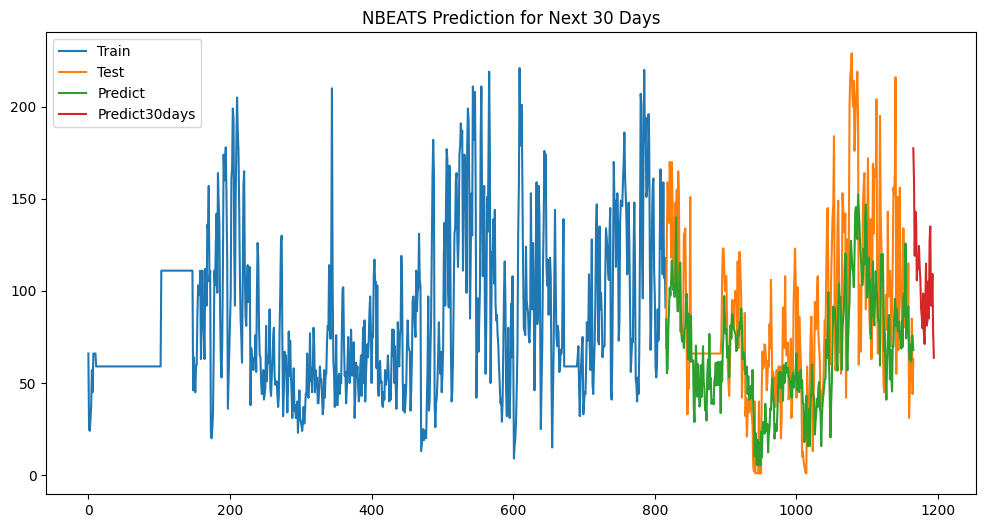

In [95]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

**NBEATS(8:2)**


In [96]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2020-06-20,66
2020-06-21,25
2020-06-22,24
2020-06-23,30
2020-06-24,38
...,...
2024-02-26,71
2024-02-27,51
2024-02-28,85


In [97]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2020-09-18,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0,25.0,66.0
2020-09-19,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0,25.0
2020-09-20,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0
2020-09-21,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0
2020-09-22,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,59.0,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,71,44.0,31.0,115.0,92.0,109.0,108.0,80.0,97.0,111.0,...,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0,128.0,74.0
2024-02-27,51,71.0,44.0,31.0,115.0,92.0,109.0,108.0,80.0,97.0,...,214.0,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0,128.0
2024-02-28,85,51.0,71.0,44.0,31.0,115.0,92.0,109.0,108.0,80.0,...,176.0,214.0,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0


In [98]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [99]:
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(932, 932, 234, 234)

In [100]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [101]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [102]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [103]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [104]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 262ms/step - loss: 31.7501 - mae: 31.7501 - mse: 1565.4023


[31.750141143798828, 31.750141143798828, 1565.40234375]

In [105]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [106]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 31.750141, 'rmse': 39.565166, 'mape': 259.9887}

In [107]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [108]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-19    217
2023-11-20    220
2023-11-21    229
2023-11-22    207
2023-11-23    200
             ... 
2024-02-26     71
2024-02-27     51
2024-02-28     85
2024-02-29     44
2024-03-01     63
Name: AQI, Length: 90, dtype: int64 -> Prediction: 163.45144653320312

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [220.         229.         207.         200.         214.
 176.         188.         203.         210.         219.
 194.          60.         103.         100.          67.
 111.         116.         148.         158.         164.
 114.          90.         110.         131.         172.
 127.          86.          77.         139.          63.
 105.         169.         131.         166.         164.
 162.         204.          97.          66.          87.
 128.         195.         140.         124.         101.
  71.          49.          45.          74.          97.
  98.       

In [109]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

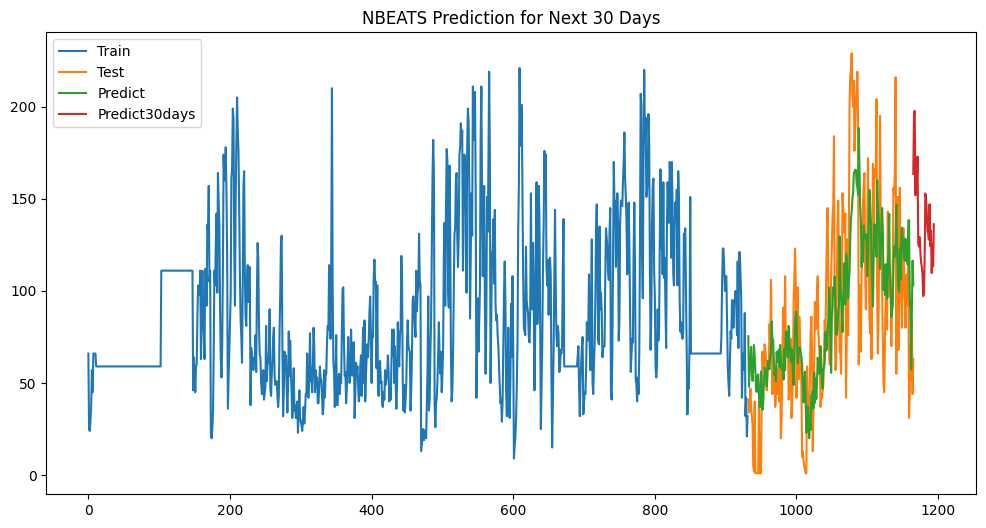

In [110]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

**NBEAT(9:1)**

In [111]:
WINDOW_SIZE=90
HORIZON=1
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2020-09-18,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0,25.0,66.0
2020-09-19,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0,25.0
2020-09-20,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0,24.0
2020-09-21,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0,30.0
2020-09-22,59,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,59.0,59.0,59.0,66.0,66.0,66.0,66.0,45.0,57.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,71,44.0,31.0,115.0,92.0,109.0,108.0,80.0,97.0,111.0,...,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0,128.0,74.0
2024-02-27,51,71.0,44.0,31.0,115.0,92.0,109.0,108.0,80.0,97.0,...,214.0,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0,128.0
2024-02-28,85,51.0,71.0,44.0,31.0,115.0,92.0,109.0,108.0,80.0,...,176.0,214.0,200.0,207.0,229.0,220.0,217.0,201.0,130.0,76.0


In [112]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [113]:
split_size = int(len(x) * 0.9)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(1049, 1049, 117, 117)

In [114]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [115]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [116]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [117]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [118]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 122ms/step - loss: 35.8296 - mae: 35.8296 - mse: 1910.2452


[35.829586029052734, 35.829586029052734, 1910.2452392578125]

In [119]:
model.evaluate(test_dataset)
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

1/1 [==============================] - 0s 128ms/step - loss: 35.8296 - mae: 35.8296 - mse: 1910.2452


In [120]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 35.829586, 'rmse': 43.706352, 'mape': 38.847073}

In [121]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [122]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-11-19    217
2023-11-20    220
2023-11-21    229
2023-11-22    207
2023-11-23    200
             ... 
2024-02-26     71
2024-02-27     51
2024-02-28     85
2024-02-29     44
2024-03-01     63
Name: AQI, Length: 90, dtype: int64 -> Prediction: 176.96124267578125

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [220.         229.         207.         200.         214.
 176.         188.         203.         210.         219.
 194.          60.         103.         100.          67.
 111.         116.         148.         158.         164.
 114.          90.         110.         131.         172.
 127.          86.          77.         139.          63.
 105.         169.         131.         166.         164.
 162.         204.          97.          66.          87.
 128.         195.         140.         124.         101.
  71.          49.          45.          74.          97.
  98.       

In [123]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

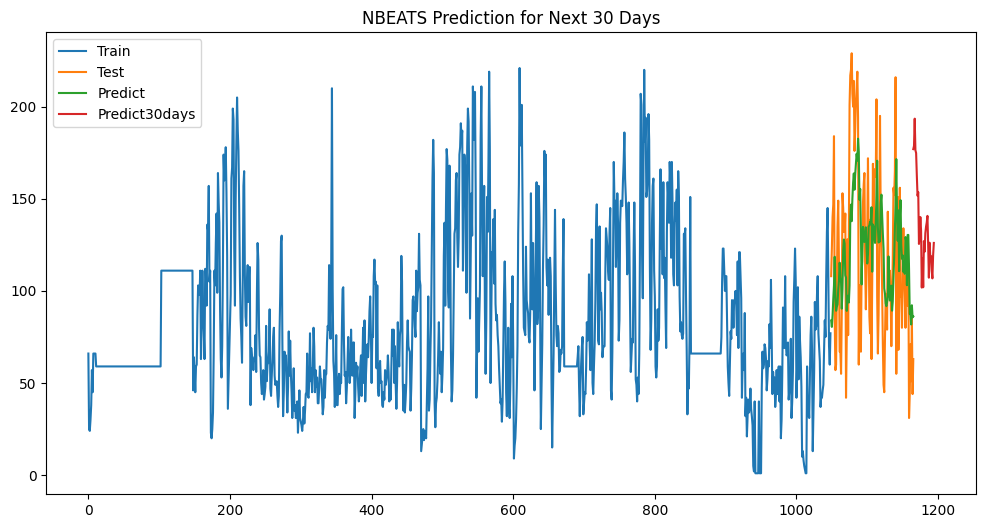

In [124]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()